### Get the updated setup scripts for `fastai` to run on Colab

In [0]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### Authentication and directory setup

In [0]:
# Authenticate Colab to use my Google Drive for data storage and retrieval
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'histology_images'

In [0]:
base_dir

'/content/gdrive/My Drive/histology_images'

In [0]:
!ls /content/gdrive/My\ Drive/histology_images/train

Brain  Intestine  Kidney  Liver  Lung  Skin  Sk_muscle


In [0]:
%cd /content/gdrive/My\ Drive/histology_images/
!tree --dirsfirst --filelimit 8

/content/gdrive/My Drive/histology_images
.
├── test
│   ├── Brain [10 entries exceeds filelimit, not opening dir]
│   ├── Intestine [20 entries exceeds filelimit, not opening dir]
│   ├── Kidney [10 entries exceeds filelimit, not opening dir]
│   ├── Liver [10 entries exceeds filelimit, not opening dir]
│   ├── Lung [11 entries exceeds filelimit, not opening dir]
│   ├── Skin
│   │   ├── Skin 1.jpg
│   │   ├── Skin 2.jpg
│   │   ├── Skin 3.jpg
│   │   ├── Skin 4.jpg
│   │   ├── Skin 5.jpg
│   │   ├── Skin 7.jpg
│   │   ├── Skin 8.jpg
│   │   └── Skin 9.jpg
│   └── Sk_muscle [12 entries exceeds filelimit, not opening dir]
└── train
    ├── Brain [50 entries exceeds filelimit, not opening dir]
    ├── Intestine [52 entries exceeds filelimit, not opening dir]
    ├── Kidney [50 entries exceeds filelimit, not opening dir]
    ├── Liver [52 entries exceeds filelimit, not opening dir]
    ├── Lung [60 entries exceeds filelimit, not opening dir]
    ├── Skin [52 entries exceeds filelimit, no

### Magics and imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

import torch 
torch.cuda.manual_seed_all(7)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Setting up the data augmentation steps

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)
len(tfms)

2

### Loading in the data in mini-btaches of 16 (keeping the same size) and normalizing with `imagenet` stats

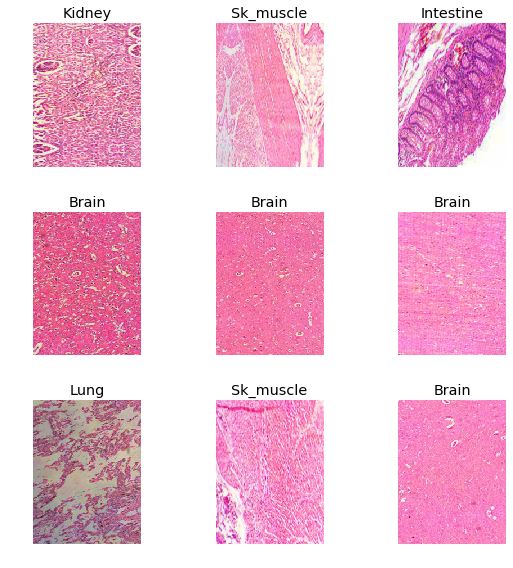

In [0]:
path = '/content/gdrive/My Drive/histology_images/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid='test',
                                  size=(256, 192), bs=16).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(8,8))

### Data classes and split details

In [0]:
print(data.classes)

['Brain', 'Intestine', 'Kidney', 'Liver', 'Lung', 'Sk_muscle', 'Skin']


In [0]:
data.label_list

LabelLists;

Train: LabelList (363 items)
x: ImageList
Image (3, 256, 192),Image (3, 256, 192),Image (3, 256, 192),Image (3, 256, 192),Image (3, 256, 192)
y: CategoryList
Skin,Skin,Skin,Skin,Skin
Path: /content/gdrive/My Drive/histology_images;

Valid: LabelList (81 items)
x: ImageList
Image (3, 256, 192),Image (3, 256, 192),Image (3, 256, 192),Image (3, 256, 192),Image (3, 256, 192)
y: CategoryList
Brain,Brain,Brain,Brain,Brain
Path: /content/gdrive/My Drive/histology_images;

Test: None

### Individual samples from the train and validation (test in this case) splits

(Image (3, 256, 192), Category Skin)


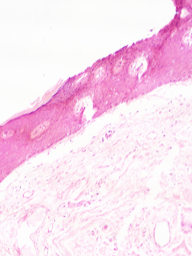

In [0]:
print(data.train_ds[0])
data.train_ds[0][0]

(Image (3, 256, 192), Category Brain)


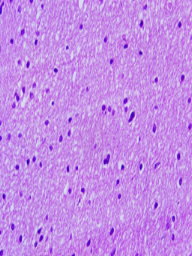

In [0]:
print(data.valid_ds[0])
data.valid_ds[0][0]

### Training with ResNet34 + Mixed precision policy + 1cycle policy

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.579372,1.337034,0.555556,00:04
1,0.832469,1.684402,0.481481,00:04
2,0.507535,1.569027,0.530864,00:04
3,0.363030,1.554038,0.543210,00:04
4,0.288633,1.598423,0.555556,00:04


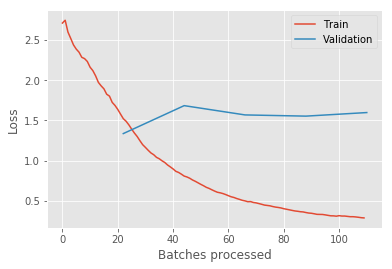

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-rn34')

### Finding optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


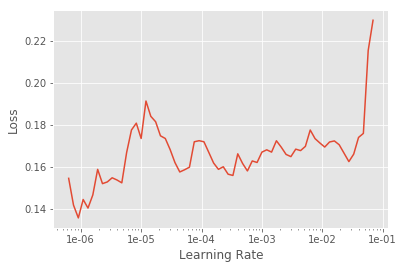

In [0]:
learn.lr_find()
learn.recorder.plot()

### Allowing the network to fully train with optimal learning rate + weight decay for better generalization

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-05, 1e-04), wd=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.154338,1.723763,0.567901,00:04
1,0.168384,1.593037,0.567901,00:04
2,0.124260,1.637072,0.530864,00:04
3,0.103949,1.635980,0.567901,00:04
4,0.111734,1.684919,0.543210,00:04


### Same above steps but this time with ResNet50 architecture + default transforms

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=(256, 192), bs=16).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.839905,1.099583,0.629630,00:04
1,0.384539,1.524854,0.592593,00:04
2,0.257580,1.513372,0.604938,00:04
3,0.185241,1.291034,0.654321,00:04
4,0.139461,1.350644,0.604938,00:04


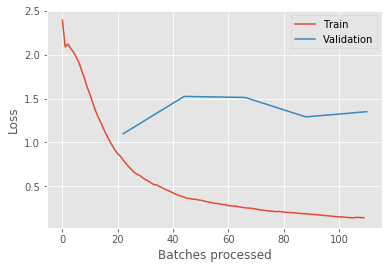

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-rn50-default-transforms')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


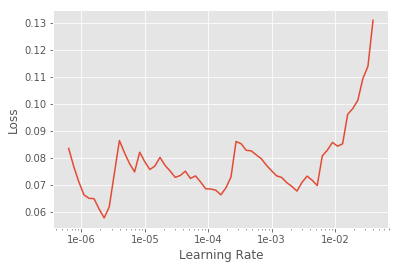

In [0]:
learn.lr_find();
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.083198,1.278003,0.617284,00:05
1,0.088143,1.252146,0.617284,00:05
2,0.063507,1.314404,0.629630,00:05
3,0.048484,1.203814,0.629630,00:04
4,0.050423,1.280764,0.641975,00:04


In [0]:
learn.freeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-05), wd=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.040103,1.216154,0.641975,00:04
1,0.038658,1.271454,0.629630,00:04
2,0.047127,1.315849,0.617284,00:04
3,0.041268,1.241349,0.641975,00:04
4,0.050628,1.226305,0.654321,00:05


In [0]:
learn.save('stage-3-rn50-default-transforms')

### Performance on validation set and training sets respectively

`tensor(0.6543)` denotes an accuracy of **65.43%**. 


In [0]:
learn.validate(learn.data.valid_dl)

[1.2263054, tensor(0.6543)]

In [0]:
learn.validate(learn.data.train_dl)

[0.0038301633, tensor(1.)]

### Creating batches of 64 + Using ResNet101

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=(256, 192), bs=64).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet101, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.692200,1.588770,0.271605,00:04
1,0.876893,1.140631,0.543210,00:04
2,0.571383,0.978990,0.679012,00:04
3,0.415427,0.965837,0.654321,00:04
4,0.319331,0.968503,0.641975,00:04


### Normalizing images with CIFAR10 stats + Using ResNet101

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=(256, 192), bs=32).normalize(cifar_stats)

learn = cnn_learner(data, models.resnet101, metrics=accuracy).to_fp16()
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.331159,1.389161,0.469136,00:05
1,0.662528,0.992649,0.740741,00:04
2,0.416170,0.848063,0.740741,00:04
3,0.288549,0.853504,0.691358,00:04
4,0.217721,0.933430,0.691358,00:04
5,0.164084,0.929605,0.703704,00:04
6,0.130097,0.929891,0.691358,00:04
7,0.102041,0.925573,0.703704,00:04


### Model's score on the validation set

In [0]:
learn.validate(learn.data.valid_dl)

[0.925573, tensor(0.7037)]

In [0]:
learn.save('stage-4-rn101-default-transforms')

### A bunch of other useful classification performance metrics

In [0]:
from sklearn.metrics import classification_report

def return_classification_report(learn):
    
    ground_truth = []
    pred_labels = []

    for i in range(len(learn.data.valid_ds)):
        temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
        temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
        pred_labels.append(temp_pred)
        ground_truth.append(temp_truth)

    assert len(pred_labels) == len(ground_truth)
    
    return classification_report(ground_truth, pred_labels, target_names=data.classes)
  
print(return_classification_report(learn))

              precision    recall  f1-score   support

       Brain       0.78      0.70      0.74        10
   Intestine       0.82      0.45      0.58        20
      Kidney       0.86      0.60      0.71        10
       Liver       0.53      0.80      0.64        10
        Lung       0.55      1.00      0.71        11
   Sk_muscle       1.00      0.92      0.96        12
        Skin       0.62      0.62      0.62         8

   micro avg       0.70      0.70      0.70        81
   macro avg       0.74      0.73      0.71        81
weighted avg       0.75      0.70      0.70        81

